C:\Users\singh\AppData\Local\Temp\ipykernel_25376\1341130196.py:43: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start='2022-01-01', periods=n_points, freq='H')


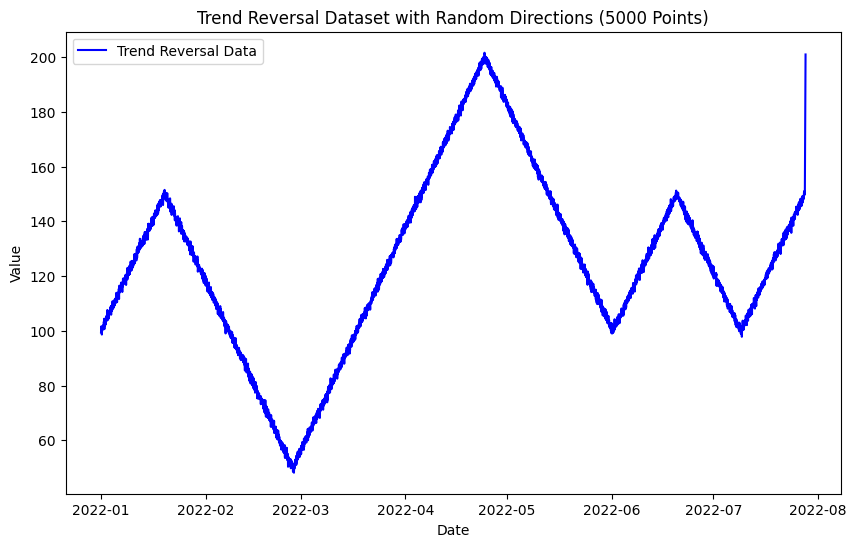

                 Date  TrendReversal
0 2022-01-01 00:00:00      99.449766
1 2022-01-01 01:00:00     100.625808
2 2022-01-01 02:00:00     100.694611
3 2022-01-01 03:00:00     101.699576
4 2022-01-01 04:00:00      99.524674


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Generate 5000 points for the trend reversal dataset
n_points = 5000
reversals = 10  # Number of trend reversals

# Calculate points per segment
points_per_segment = n_points // (reversals + 1)

# Generate the trend reversals with random directions
trend_data = []

current_value = 100  # Starting value

for i in range(reversals + 1):
    # Randomly choose between an upward or downward trend
    direction = np.random.choice(['up', 'down'])
    
    if direction == 'up':
        trend = np.linspace(current_value, current_value + 50, points_per_segment) + np.random.normal(0, 1, points_per_segment)
        current_value += 50  # Update current value for next segment
    else:
        trend = np.linspace(current_value, current_value - 50, points_per_segment) + np.random.normal(0, 1, points_per_segment)
        current_value -= 50  # Update current value for next segment

    trend_data.extend(trend)

# Handle any remaining points (in case n_points is not divisible by number of segments)
remaining_points = n_points - len(trend_data)
if remaining_points > 0:
    final_trend = np.linspace(trend_data[-1], trend_data[-1] + 50, remaining_points) + np.random.normal(0, 1, remaining_points)
    trend_data.extend(final_trend)

# Convert to numpy array
trend_data = np.array(trend_data)

# Create a date range for the dataset
date_range = pd.date_range(start='2022-01-01', periods=n_points, freq='H')

# Create DataFrame
df = pd.DataFrame({'Date': date_range, 'TrendReversal': trend_data})

# Plot the generated trend reversal data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['TrendReversal'], color='blue', label='Trend Reversal Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Trend Reversal Dataset with Random Directions (5000 Points)')
plt.legend()
plt.show()

# Display the first few rows of the DataFrame
print(df.head())


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [3]:
# Do adf test for adj close
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['TrendReversal'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: 0.184179
p-value: 0.971360


In [4]:
# Difference trend reversal data
df['TrendReversal'] = df['TrendReversal'].diff().fillna(0)

In [5]:
# Do adf test for adj close
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['TrendReversal'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.396558
p-value: 0.910672


In [6]:
df['TrendReversal'] = df['TrendReversal'].diff().fillna(0)

In [7]:
# Do adf test for adj close
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['TrendReversal'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -16.680900
p-value: 0.000000


In [8]:
# diff_data equals numpy df['TrendReversal]
diff_data = df['TrendReversal'].to_numpy()

In [9]:
def create_sequences(data, n_steps_in, n_steps_out=1):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i:i + n_steps_in])
        y.append(data[i + n_steps_in:i + n_steps_in + n_steps_out])  # Slice for next step
    return np.array(X), np.array(y).reshape(-1, n_steps_out)  # Reshape y properly

# Generate sequences and targets from the differenced data
n_steps_in = 50  # Use last 50 steps to predict the next step
n_steps_out = 1  # Predict 1 step ahead

# Generate sequences from `diff_data`
X, y = create_sequences(diff_data, n_steps_in, n_steps_out)

# Now X and y should have the same number of samples
print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (4950, 50), y shape: (4950, 1)


In [10]:
from sklearn.model_selection import train_test_split

# Split the data into training/validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Further split training set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, shuffle=False)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(2)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(2)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(2)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [11]:
import torch
import torch.nn as nn

class JordanRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.0):
        super(JordanRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size = input_size
        self.rnn = nn.RNN(input_size + 1, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        sequence_length = x.size(1)

        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        output = torch.zeros(batch_size, 1, 1).to(x.device)

        for t in range(sequence_length):
            combined_input = torch.cat((x[:, t:t+1, :], output), dim=2)
            out, h0 = self.rnn(combined_input, h0)
            output = self.fc(out)

        return output.squeeze(1)  # Return the final output


Epoch [5/100], Train Loss: 5.8918, Val Loss: 6.1330
Epoch [10/100], Train Loss: 5.6050, Val Loss: 5.8378
Epoch [15/100], Train Loss: 5.3466, Val Loss: 5.5838
Epoch [20/100], Train Loss: 5.1080, Val Loss: 5.3389
Epoch [25/100], Train Loss: 4.8846, Val Loss: 5.0958
Epoch [30/100], Train Loss: 4.6824, Val Loss: 4.8709
Epoch [35/100], Train Loss: 4.4784, Val Loss: 4.6625
Epoch [40/100], Train Loss: 4.2954, Val Loss: 4.4744
Epoch [45/100], Train Loss: 4.1423, Val Loss: 4.3176
Epoch [50/100], Train Loss: 3.9746, Val Loss: 4.1385
Epoch [55/100], Train Loss: 3.8120, Val Loss: 3.9616
Epoch [60/100], Train Loss: 3.6543, Val Loss: 3.7983
Epoch [65/100], Train Loss: 3.5026, Val Loss: 3.6419
Epoch [70/100], Train Loss: 3.3483, Val Loss: 3.4838
Epoch [75/100], Train Loss: 3.1970, Val Loss: 3.3224
Epoch [80/100], Train Loss: 3.0456, Val Loss: 3.1633
Epoch [85/100], Train Loss: 2.8937, Val Loss: 3.0060
Epoch [90/100], Train Loss: 2.7419, Val Loss: 2.8499
Epoch [95/100], Train Loss: 2.5930, Val Loss: 2

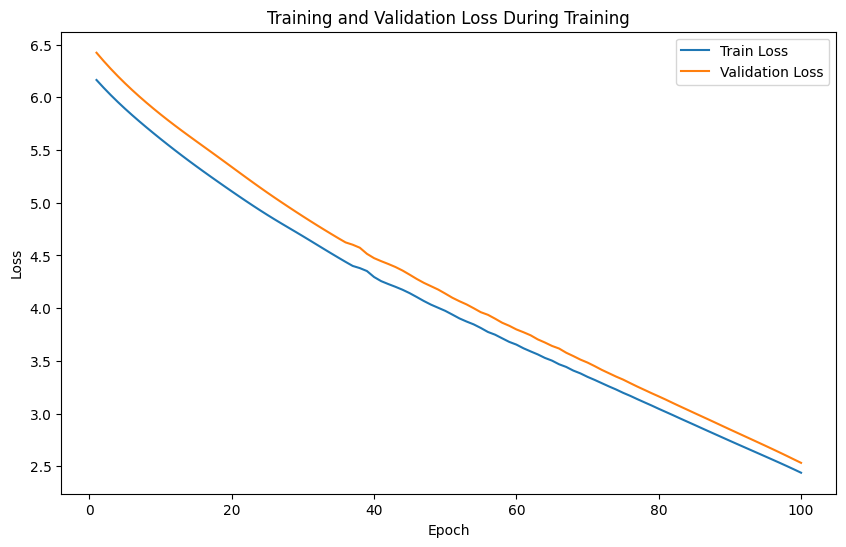

In [12]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Early stopping to stop training when validation loss doesn't improve.
        Args:
        patience (int): How long to wait after last time validation loss improved.
                        Default: 5
        min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                           Default: 0
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Initialize the model, loss, optimizer, and early stopping
input_size = 1
hidden_size = 64
output_size = 1
num_epochs = 100
learning_rate = 0.001

model = JordanRNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

early_stopping = EarlyStopping(patience=10, min_delta=0.001)

import matplotlib.pyplot as plt

# Initialize lists to store the losses
train_losses = []
val_losses = []

# Training loop with early stopping
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass for training
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Store the training loss
    train_losses.append(loss.item())

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
    
    # Store the validation loss
    val_losses.append(val_loss.item())

    # Early stopping check
    early_stopping(val_loss.item())
    if early_stopping.early_stop and epoch > 50:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss During Training')
plt.legend()
plt.show()


In [13]:
# Evaluate on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')


Test Loss: 2.3862


In [15]:
# Evaluate on the test set
model.eval()
criterion2 = nn.L1Loss()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion2(test_outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')


Test Loss: 1.1941


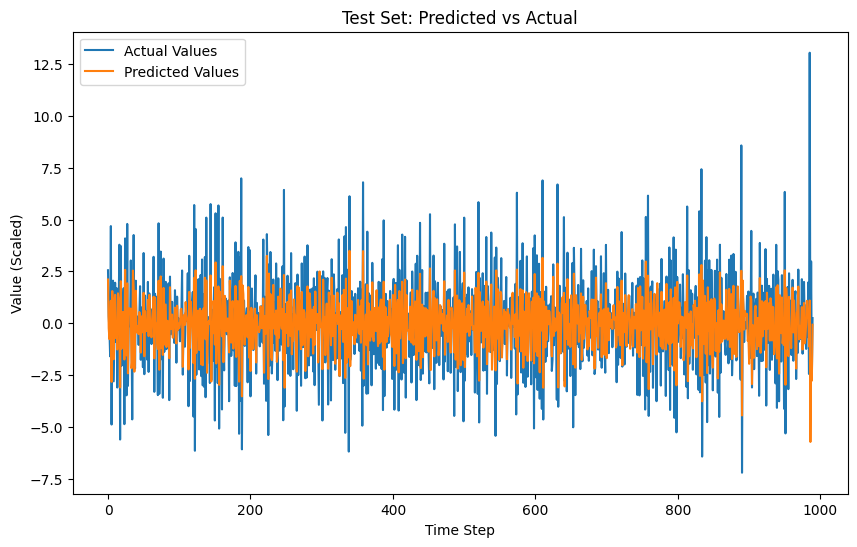

In [14]:
import matplotlib.pyplot as plt
# Plot predicted vs actual values
predicted_test = test_outputs.squeeze().numpy()
actual_test = y_test_tensor.numpy()

plt.figure(figsize=(10, 6))
plt.plot(actual_test, label='Actual Values')
plt.plot(predicted_test, label='Predicted Values')
plt.title('Test Set: Predicted vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Value (Scaled)')
plt.legend()
plt.show()
